In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional,GRU,Input, Dense, Activation, RepeatVector, Dropout, Concatenate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Error: ",e)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel
from transformers import AutoTokenizer, TFXLNetModel

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix

from scipy.stats import pearsonr

import joblib

import numpy as np
import pickle

pd.set_option('display.max_colwidth', 50)


In [2]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

In [3]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
# Load data from CSV file
import pandas as pd
df = pd.read_csv('Final_Dataset_preprocessed_english.csv')#.sample(10000).reset_index(drop='index')
df.head()

,text,label,text_preprocessed,count_sentenc_text,count_words_text,num_nouns_text,num_verbs_text,num_adj_text,num_adv_text,sentiment_avg_text,features
0,donald trump just couldn t wish all americans ...,0,donald trump wish american happi new year leav...,1,287,244,9,23,11,0.9423,donald trump wish american happi new year leav...
1,house intelligence committee chairman devin nu...,0,hous intellig committe chairman devin nune go ...,1,179,148,6,23,2,0.7943,hous intellig committe chairman devin nune go ...
2,on friday it was revealed that former milwauke...,0,friday reveal former milwauke sheriff david cl...,1,339,308,9,13,9,-0.9946,friday reveal former milwauke sheriff david cl...
3,on christmas day donald trump announced that h...,0,christma day donald trump announc would back w...,1,265,227,14,14,10,0.5859,christma day donald trump announc would back w...
4,pope francis used his annual christmas day mes...,0,pope franci use annual christma day messag reb...,1,211,181,16,9,5,-0.2960,pope franci use annual christma day messag reb...


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers

X = df['text']
y = df['label']

#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = pad_sequences(test_sequences,maxlen=MAX_LEN)

X_train_seq.shape[1]

Train vocabulary size: 339294


512

Simple DNN Model

In [6]:
# Step 1: Load and preprocess your dataset (replace 'df' and 'labels' with your actual data)
# For this example, let's assume you have a DataFrame 'df' with a 'text' column and a 'label' column (0 for fake, 1 for real).
X = df['text']
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Tokenize the text data
max_words = 10000  # Maximum number of words to keep in the vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent input shape
max_sequence_length = 100  # Choose an appropriate sequence length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [44]:
# Step 3: Build and train the DNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
model.add(Flatten())  # You can also use LSTM or other recurrent layers here
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Step 4: Model Evaluation
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

Epoch 1/5
1411/1411 [==============================] - 9s 6ms/step - loss: 0.6541 - accuracy: 0.5448 - val_loss: 0.6368 - val_accuracy: 0.5677
Epoch 2/5
1411/1411 [==============================] - 8s 6ms/step - loss: 0.6034 - accuracy: 0.5826 - val_loss: 0.6330 - val_accuracy: 0.5731
Epoch 3/5
1411/1411 [==============================] - 9s 6ms/step - loss: 0.5716 - accuracy: 0.6012 - val_loss: 0.6485 - val_accuracy: 0.5686
Epoch 4/5
1411/1411 [==============================] - 8s 6ms/step - loss: 0.5584 - accuracy: 0.6099 - val_loss: 0.6831 - val_accuracy: 0.5600
Epoch 5/5
1411/1411 [==============================] - 9s 6ms/step - loss: 0.5501 - accuracy: 0.6147 - val_loss: 0.7047 - val_accuracy: 0.5558


In [45]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.54      0.90      0.68     14629
           1       0.63      0.18      0.28     13590

    accuracy                           0.55     28219
   macro avg       0.59      0.54      0.48     28219
weighted avg       0.58      0.55      0.49     28219



Simple LSTM Model

In [8]:
# Define the model
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_seq,
                    y_train,
                    epochs=20,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)])
                    

Epoch 1/20
1323/1323 [==============================] - 141s 103ms/step - loss: 0.6692 - accuracy: 0.5346 - val_loss: 0.6472 - val_accuracy: 0.5511
Epoch 2/20
1323/1323 [==============================] - 134s 101ms/step - loss: 0.6351 - accuracy: 0.5643 - val_loss: 0.6427 - val_accuracy: 0.5554
Epoch 3/20
1323/1323 [==============================] - 136s 103ms/step - loss: 0.6138 - accuracy: 0.5875 - val_loss: 0.6428 - val_accuracy: 0.5736
Epoch 4/20
1323/1323 [==============================] - 136s 103ms/step - loss: 0.5911 - accuracy: 0.6139 - val_loss: 0.6196 - val_accuracy: 0.6231
Epoch 5/20
1323/1323 [==============================] - 133s 100ms/step - loss: 0.5986 - accuracy: 0.6175 - val_loss: 0.6927 - val_accuracy: 0.5155
Epoch 6/20
1323/1323 [==============================] - 131s 99ms/step - loss: 0.6921 - accuracy: 0.5191 - val_loss: 0.6906 - val_accuracy: 0.5215
Epoch 7/20
1323/1323 [==============================] - 131s 99ms/step - loss: 0.6741 - accuracy: 0.5470 - val_lo

1103/1103 [==============================] - 19s 18ms/step - loss: 0.6198 - accuracy: 0.6272
Test Loss: 0.6198236346244812
Test Accuracy: 0.6271936297416687


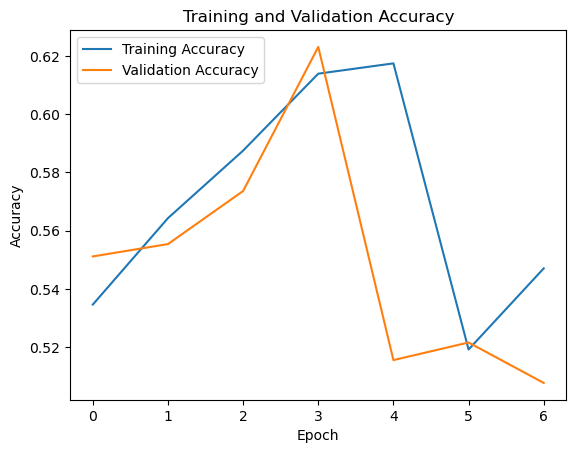

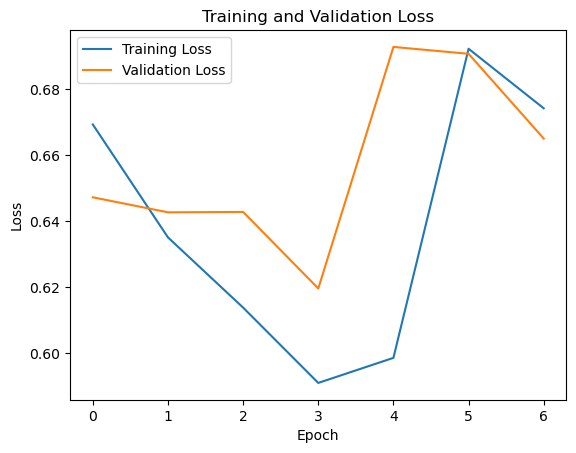

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_train_val_loss_acc(history)

              precision    recall  f1-score   support

           0       0.59      0.93      0.72     18231
           1       0.80      0.30      0.44     17042

    accuracy                           0.63     35273
   macro avg       0.70      0.62      0.58     35273
weighted avg       0.69      0.63      0.58     35273



(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

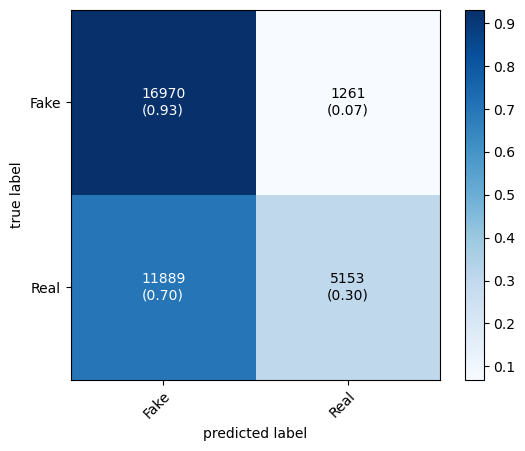

In [10]:
## print classification report
y_hat = model.predict(X_test_seq)
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

conf_mat = confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])

Simple Bi-LSTM Model

Epoch 1/20
1323/1323 [==============================] - 257s 190ms/step - loss: 0.6744 - accuracy: 0.5336 - val_loss: 0.6543 - val_accuracy: 0.5534
Epoch 2/20
1323/1323 [==============================] - 251s 190ms/step - loss: 0.6377 - accuracy: 0.5665 - val_loss: 0.6409 - val_accuracy: 0.5360
Epoch 3/20
1323/1323 [==============================] - 250s 189ms/step - loss: 0.6182 - accuracy: 0.5884 - val_loss: 0.6328 - val_accuracy: 0.5928
Epoch 4/20
1323/1323 [==============================] - 250s 189ms/step - loss: 0.5919 - accuracy: 0.6458 - val_loss: 0.6248 - val_accuracy: 0.6040
Epoch 5/20
1323/1323 [==============================] - 250s 189ms/step - loss: 0.5635 - accuracy: 0.6636 - val_loss: 0.6172 - val_accuracy: 0.6581
Epoch 6/20
1323/1323 [==============================] - 251s 190ms/step - loss: 0.5234 - accuracy: 0.7001 - val_loss: 0.6262 - val_accuracy: 0.6554
Epoch 7/20
1323/1323 [==============================] - 250s 189ms/step - loss: 0.5213 - accuracy: 0.6919 - val_

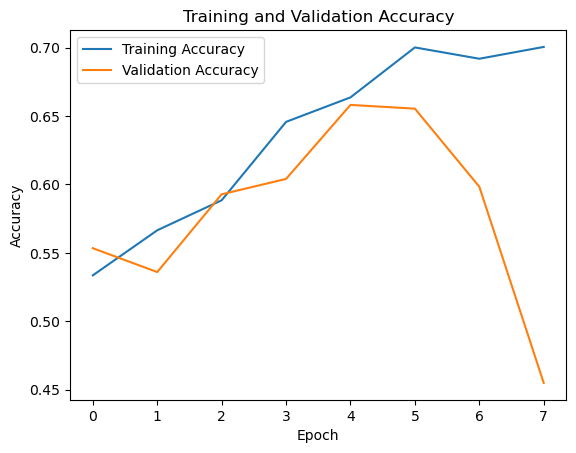

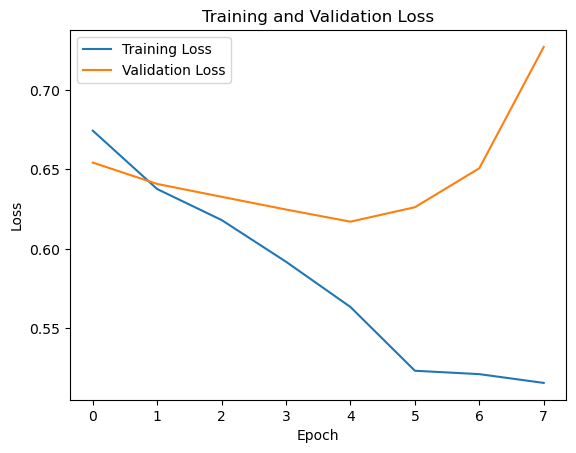

In [6]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
# model.summary()

#Fit the model
history = model.fit(X_train_seq,
                    y_train,
                    epochs=20,
                    validation_split = 0.2,
                    batch_size = 64,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# plot learning curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot validation curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1103/1103 [==============================] - 40s 36ms/step - loss: 0.6246 - accuracy: 0.6552
Test Loss: 0.6245578527450562
Test Accuracy: 0.6551753282546997
              precision    recall  f1-score   support

           0       0.62      0.85      0.72     18231
           1       0.73      0.45      0.56     17042

    accuracy                           0.66     35273
   macro avg       0.68      0.65      0.64     35273
weighted avg       0.68      0.66      0.64     35273



(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

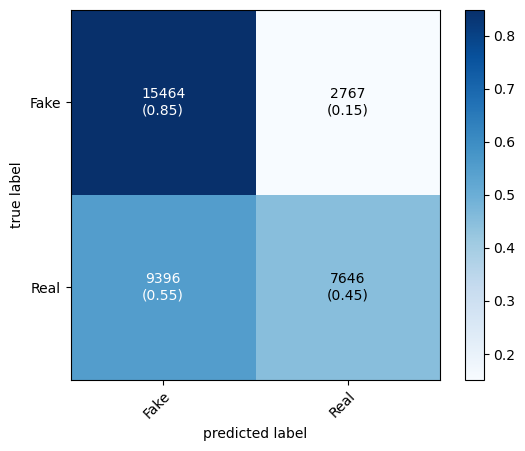

In [7]:
from mlxtend.plotting import plot_confusion_matrix

#Evaluate the model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

conf_mat = confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])

CNN Simple

In [21]:
# Step 3: Build and train the CNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# Step 4: Model Evaluation
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Print classification report
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/20
1411/1411 [==============================] - 12s 9ms/step - loss: 0.6463 - accuracy: 0.5563 - val_loss: 0.6187 - val_accuracy: 0.5705
Epoch 2/20
1411/1411 [==============================] - 11s 8ms/step - loss: 0.5972 - accuracy: 0.5869 - val_loss: 0.6110 - val_accuracy: 0.5828
Epoch 3/20
1411/1411 [==============================] - 11s 8ms/step - loss: 0.5743 - accuracy: 0.5986 - val_loss: 0.6286 - val_accuracy: 0.5664
Epoch 4/20
1411/1411 [==============================] - 11s 8ms/step - loss: 0.5616 - accuracy: 0.6024 - val_loss: 0.6622 - val_accuracy: 0.5790
Epoch 5/20
1411/1411 [==============================] - 11s 8ms/step - loss: 0.5544 - accuracy: 0.6054 - val_loss: 0.6963 - val_accuracy: 0.5779
              precision    recall  f1-score   support

           0       0.55      0.97      0.70     14629
           1       0.82      0.16      0.27     13590

    accuracy                           0.58     28219
   macro avg       0.69      0.57      0.49     28219
wei

BERT (with only text)

In [5]:
# Split data into train and test sets
X = df['text'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input texts
# X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
# X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Load tokenized data
with open('X_train_tokenized_BERT_uncased.pkl', 'rb') as f:
    X_train_tokenized = pickle.load(f)

with open('X_test_tokenized_BERT_uncased.pkl', 'rb') as f:
    X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
706/706 [==============================] - 960s 1s/step - loss: 0.4565 - accuracy: 0.8215 - val_loss: 0.3229 - val_accuracy: 0.8607
Epoch 2/20
706/706 [==============================] - 900s 1s/step - loss: 0.2113 - accuracy: 0.9107 - val_loss: 0.2782 - val_accuracy: 0.8812
Epoch 3/20
706/706 [==============================] - 902s 1s/step - loss: 0.1464 - accuracy: 0.9403 - val_loss: 0.3243 - val_accuracy: 0.8722
Epoch 4/20
706/706 [==============================] - 905s 1s/step - loss: 0.1088 - accuracy: 0.9566 - val_loss: 0.3252 - val_accuracy: 0.8827
Epoch 5/20
706/706 [==============================] - 953s 1s/step - loss: 0.0887 - accuracy: 0.9647 - val_loss: 0.3409 - val_accuracy: 0.8882
Epoch 6/20
706/706 [==============================] - 909s 1s/step - loss: 0.0759 - accuracy: 0.9713 - val_loss: 0.4075 - val_accuracy: 0.8867
Epoch 7/20
706/706 [==============================] - 903s 1s/step - loss: 0.0689 - accuracy: 0.9742 - val_loss: 0.3953 - val_accuracy: 0.8851

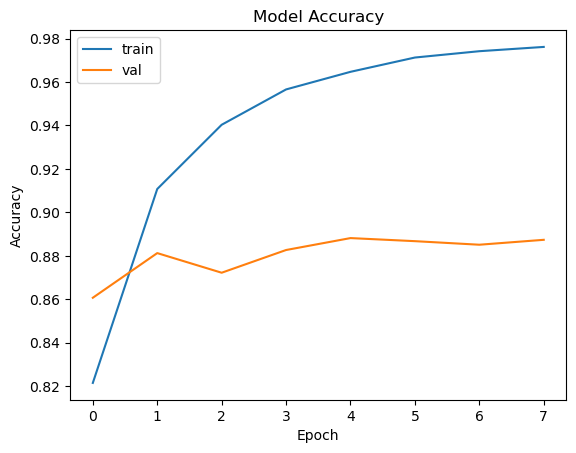

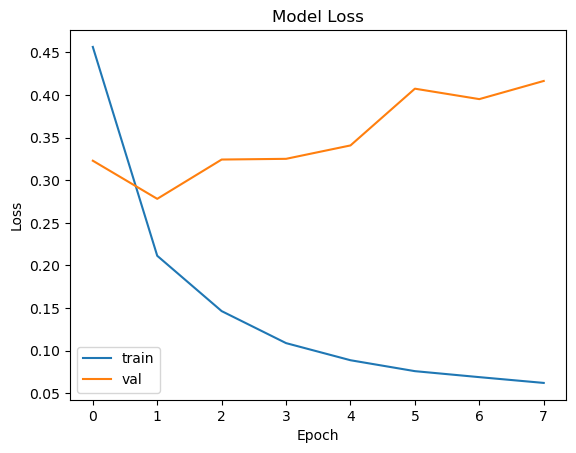

In [7]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=128,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     14629
           1       0.89      0.88      0.88     13590

    accuracy                           0.89     28219
   macro avg       0.89      0.89      0.89     28219
weighted avg       0.89      0.89      0.89     28219



RoBERTa with only text

In [6]:
# Split data into train and test sets
X = df['text'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Save tokenized data
with open('X_train_tokenized_roBERTa_base.pkl', 'wb') as f:
    pickle.dump(X_train_tokenized, f)

with open('X_test_tokenized_roBERTa_base.pkl', 'wb') as f:
   pickle.dump(X_test_tokenized, f)

# Load tokenized data
# with open('X_train_tokenized_roBERTa_base.pkl', 'rb') as f:
#     X_train_tokenized = pickle.load(f)

# with open('X_test_tokenized_roBERTa_base.pkl', 'rb') as f:
#     X_test_tokenized = pickle.load(f)

In [7]:
# Load the pre-trained BERT model
roberta_model = TFBertModel.from_pretrained('roberta-base')

# Freeze the pre-trained layers
for layer in roberta_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = roberta_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at roberta-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
706/706 [==============================] - 967s 1s/step - loss: 1.6117 - accuracy: 0.6400 - val_loss: 0.8283 - val_accuracy: 0.6387
Epoch 2/20
706/706 [==============================] - 947s 1s/step - loss: 0.6149 - accuracy: 0.7177 - val_loss: 0.7081 - val_accuracy: 0.6606
Epoch 3/20
706/706 [==============================] - 947s 1s/step - loss: 0.4987 - accuracy: 0.7592 - val_loss: 0.5104 - val_accuracy: 0.7466
Epoch 4/20
706/706 [==============================] - 956s 1s/step - loss: 0.4813 - accuracy: 0.7663 - val_loss: 0.5553 - val_accuracy: 0.7080
Epoch 5/20
706/706 [==============================] - 959s 1s/step - loss: 0.4546 - accuracy: 0.7808 - val_loss: 0.7478 - val_accuracy: 0.6712
Epoch 6/20
706/706 [==============================] - 942s 1s/step - loss: 0.4517 - accuracy: 0.7811 - val_loss: 0.4890 - val_accuracy: 0.7491
Epoch 7/20
706/706 [==============================] - 941s 1s/step - loss: 0.4537 - accuracy: 0.7801 - val_loss: 0.4811 - val_accuracy: 0.7558

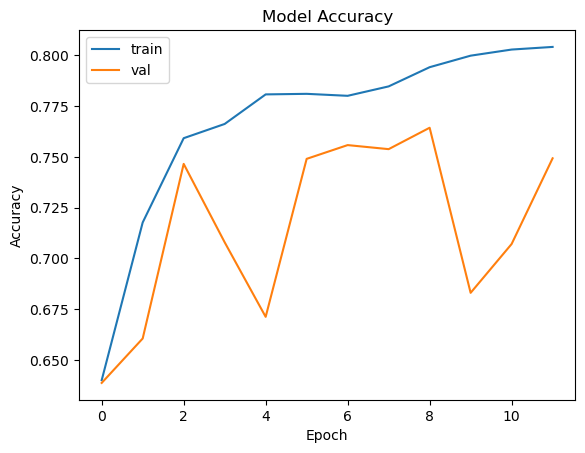

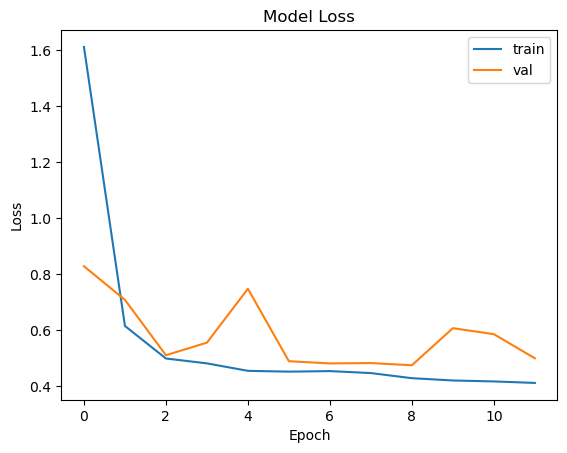

In [8]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=128,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76     14629
           1       0.72      0.84      0.78     13590

    accuracy                           0.77     28219
   macro avg       0.77      0.77      0.77     28219
weighted avg       0.77      0.77      0.77     28219



XLNET (with only text)

In [5]:
# Split data into train and test sets
X = df['text'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Load the BERT tokenizer
# tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

# # Tokenize the input texts
# X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
# X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# # Save tokenized data
# with open('X_train_tokenized_XLNET_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_train_tokenized, f)

# with open('X_test_tokenized_XLNET_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_test_tokenized, f)

# Load tokenized data
with open('X_train_tokenized_XLNET_base_cased.pkl', 'rb') as f:
    X_train_tokenized = pickle.load(f)

with open('X_train_tokenized_XLNET_base_cased.pkl', 'rb') as f:
    X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained BERT model
model = TFXLNetModel.from_pretrained("xlnet-base-cased")

# Freeze the pre-trained layers
for layer in model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [7]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=16,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

Epoch 1/20
5644/5644 [==============================] - 1806s 315ms/step - loss: 0.8860 - accuracy: 0.7090 - val_loss: 0.4826 - val_accuracy: 0.7368
Epoch 2/20
5644/5644 [==============================] - 1707s 302ms/step - loss: 0.4497 - accuracy: 0.7765 - val_loss: 0.4170 - val_accuracy: 0.8000
Epoch 3/20
5644/5644 [==============================] - 1704s 302ms/step - loss: 0.4039 - accuracy: 0.8071 - val_loss: 0.4257 - val_accuracy: 0.7945
Epoch 4/20
5644/5644 [==============================] - 1758s 311ms/step - loss: 0.3705 - accuracy: 0.8296 - val_loss: 0.4327 - val_accuracy: 0.8248
Epoch 5/20
5644/5644 [==============================] - 1772s 314ms/step - loss: 0.3498 - accuracy: 0.8425 - val_loss: 0.4222 - val_accuracy: 0.8136
Epoch 6/20
5644/5644 [==============================] - 1770s 314ms/step - loss: 0.3329 - accuracy: 0.8510 - val_loss: 0.4146 - val_accuracy: 0.8236
Epoch 7/20
5644/5644 [==============================] - 1779s 315ms/step - loss: 0.3219 - accuracy: 0.8596

ValueError: Data cardinality is ambiguous:
  x sizes: 112873
  y sizes: 28219
Make sure all arrays contain the same number of samples.

1764/1764 [==============================] - 352s 200ms/step - loss: 0.4234 - accuracy: 0.8254
Test loss: 0.423, Test accuracy: 0.825


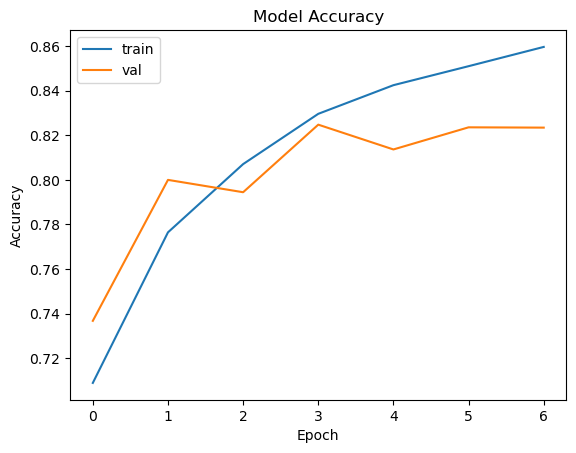

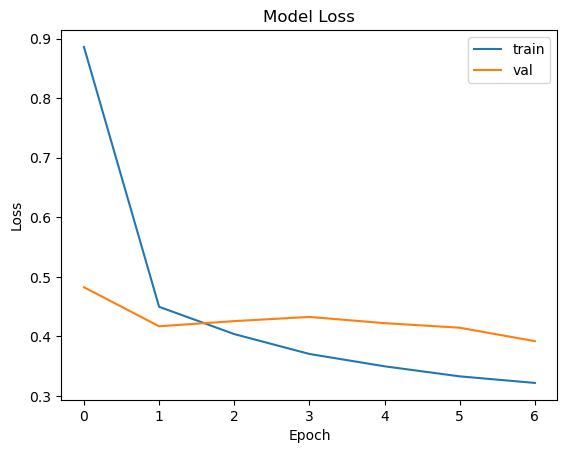

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=16)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [13]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82     14629
           1       0.79      0.86      0.83     13590

    accuracy                           0.83     28219
   macro avg       0.83      0.83      0.83     28219
weighted avg       0.83      0.83      0.83     28219

